<a href="https://colab.research.google.com/github/itsmaul/bangkit-capstone/blob/main/All_Integrated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cashflow Analysis**

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def preprocess_data(data):
  # Membaca file dataset
  data = pd.DataFrame(pd.read_json(data))

  # Menghitung total_income dan total_expense
  data['total_income'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Income' else 0, axis=1)
  data['total_expense'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Expense' else 0, axis=1)

  # Menghitung net_cashflow
  data['net_cashflow'] = data['total_income'] - data['total_expense']

  # Mengelompokkan berdasarkan bulan
  data['month'] = pd.to_datetime(data['date']).dt.to_period('M')

  # Menghitung total per bulan
  summary = data.groupby('month').agg(
    total_income = ('total_income', 'sum'),
    total_expense = ('total_expense', 'sum'),
    net_cashflow = ('net_cashflow', 'sum')
  ).reset_index()

  return summary

In [ ]:
preprocess_data('merger_dataset.json')

,month,total_income,total_expense,net_cashflow
0,2023-08,1390000,1412950,-22950
1,2023-09,1607000,1443530,163470
2,2023-10,1510000,1652785,-142785
3,2023-11,1200000,1077068,122932
4,2023-12,1750000,1829508,-79508
5,2024-01,9735000,11400361,-1665361
6,2024-02,19201015,18971500,229515
7,2024-03,3620000,2670818,949182
8,2024-04,6250101,4098822,2151279
9,2024-05,4527000,6434944,-1907944


In [ ]:
#Min-Max Scaler Initialization
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
def time_series(data):
  # Rescaling dengan MinMaxScaler
  total_income = scaler.fit_transform(data[['total_income']])
  total_expense = scaler.fit_transform(data[['total_expense']])
  net_cashflow = scaler.fit_transform(data[['net_cashflow']])

  # Assign value variabel time dan series
  time = pd.to_datetime(data['month'].astype(str)).tolist()
  income = data['total_income'].tolist()
  expense = data['total_expense'].tolist()
  net_cashflow = data['net_cashflow'].tolist()

  return time, income, expense, net_cashflow

In [ ]:
DATA = 'merger_dataset.json'
TIME, INCOME, EXPENSE, NET_CASHFLOW = time_series(preprocess_data(DATA))

INCOME_SCALED = scaler.inverse_transform(np.array(INCOME).reshape(-1,1)).flatten()
EXPENSE_SCALED = scaler.inverse_transform(np.array(EXPENSE).reshape(-1,1)).flatten()
NET_CASHFLOW_SCALED = scaler.inverse_transform(np.array(NET_CASHFLOW).reshape(-1,1)).flatten()

In [ ]:
#Visualisasi Data

def plot_value(time, value, label):
  plt.plot(time, value, label = label)
  plt.xlabel("Bulan Transaksi")
  plt.ylabel("Jumlah Uang")
  plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
  plt.gcf().autofmt_xdate()
  plt.show()

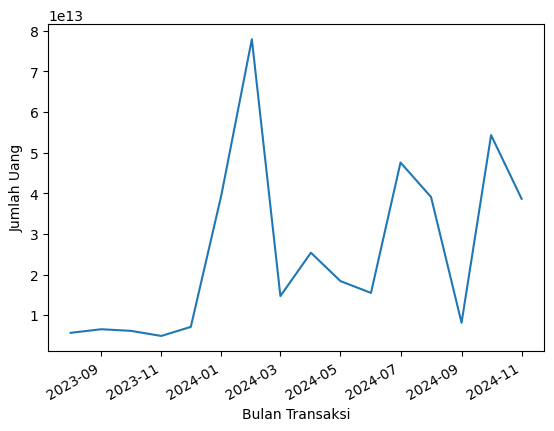

In [ ]:
plot_value(TIME, INCOME_SCALED, "Pemasukan")

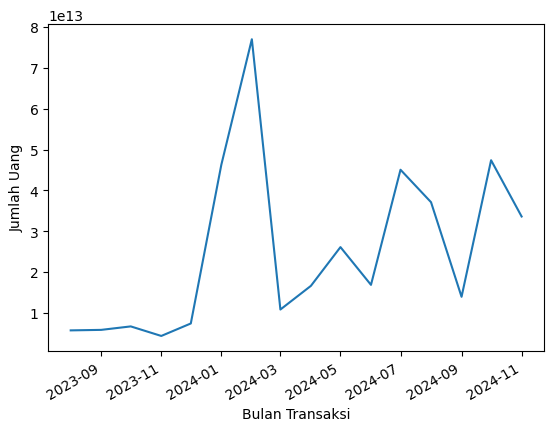

In [ ]:
plot_value(TIME, EXPENSE_SCALED, "Pengeluaran")

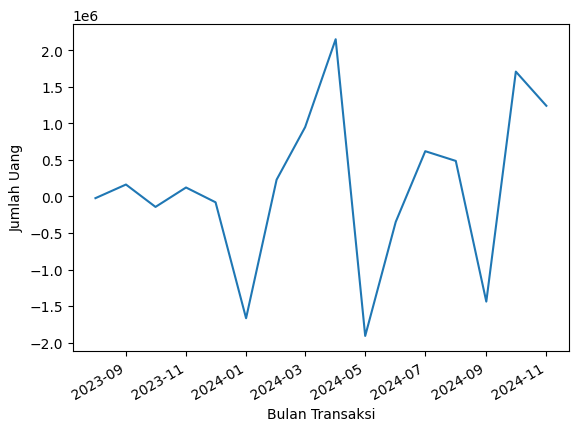

In [ ]:
plot_value(TIME, NET_CASHFLOW, "Net Cashflow")

In [ ]:
# Format data JSON
data_for_export = {
  "cashflow_analysis": [
    {
      "time": TIME[i].strftime('%Y-%m'),
      "total_income": INCOME[i],
      "total_expense": EXPENSE[i],
      "net_cashflow": NET_CASHFLOW[i]
    }
    for i in range(len(TIME))
  ]
}

# Simpan ke JSON
with open('clean_data.json', 'w') as json_file:
    json.dump(data_for_export, json_file, indent=1)

# **Anomaly Detection**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
class AdvancedFinancialAnomalyDetector:
    def __init__(self, contamination=0.05):
        self.scaler_amount = StandardScaler()
        self.model = IsolationForest(
            contamination=contamination,
            random_state=42,
            max_samples='auto',
            max_features=1.0
        )
        self.amount_column = None

    def preprocess_data(self, data):
        for col in ['amount', 'income', 'expense']:
            if col in data.columns:
                self.amount_column = col
                break
        else:
            raise KeyError("Neither 'amount', 'income', nor 'expense' column found in data")

        # Assuming you have a 'date' column in your data
        data['date'] = pd.to_datetime(data['date'])
        data['day_of_week'] = data['date'].dt.dayofweek
        data['month'] = data['date'].dt.month
        data['day_of_month'] = data['date'].dt.day

        # Normalisasi amount
        features = [self.amount_column, 'day_of_week', 'month', 'day_of_month']
        X = data[features].copy()
        X[self.amount_column] = self.scaler_amount.fit_transform(X[[self.amount_column]])

        return X

    def detect_anomalies(self, data):
        """
        Deteksi anomali dengan informasi detail
        """
        X = self.preprocess_data(data)

        # Prediksi anomali
        anomaly_labels = self.model.fit_predict(X)
        anomaly_scores = -self.model.score_samples(X)

        # Tambahkan informasi ke dataframe asli
        data['is_anomaly'] = anomaly_labels == -1
        data['anomaly_score'] = anomaly_scores

        return data

    def visualize_anomalies(self, data):
        """
        Visualisasi anomali dengan beberapa plot
        """
        plt.figure(figsize=(16, 12))
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

        # 1. Scatter Plot Anomali
        plt.subplot(2, 2, (1, 2))
        plt.title('Deteksi Anomali Keuangan', fontsize=12)
        plt.scatter(
            data[~data['is_anomaly']]['date'],
            data[~data['is_anomaly']][self.amount_column],
            c='blue',
            alpha=0.5,
            label='Normal'
        )
        plt.scatter(
            data[data['is_anomaly']]['date'],
            data[data['is_anomaly']][self.amount_column],
            c='red',
            label='Anomali'
        )
        plt.xlabel('Tanggal')
        plt.ylabel('Jumlah Transaksi')
        plt.legend()
        plt.xticks(rotation=45)

        # 2. Histogram Anomali Scores
        plt.subplot(2, 2, 3)
        plt.title('Distribusi Anomaly Scores', fontsize=12)
        sns.histplot(
            data=data,
            x='anomaly_score',
            hue='is_anomaly',
            multiple='stack'
        )
        plt.xlabel('Anomaly Score')
        plt.ylabel('Frekuensi')

        # 3. Pie Chart Proporsi Anomali
        plt.subplot(2, 2, 4)
        anomaly_counts = data['is_anomaly'].value_counts()
        plt.title('Proporsi Anomali', fontsize=12)
        plt.pie(
            anomaly_counts,
            labels=['Normal', 'Anomali'],
            autopct='%1.1f%%',
            colors=['blue', 'red']
        )

        plt.tight_layout()
        plt.show()

    def detailed_anomaly_report(self, data):
        """
        Laporan detail anomali
        """
        anomalies = data[data['is_anomaly']]

        print("=== LAPORAN DETEKSI ANOMALI ===")
        print(f"Total Transaksi: {len(data)}")
        print(f"Jumlah Anomali: {len(anomalies)}")
        print(f"Persentase Anomali: {len(anomalies)/len(data)*100:.2f}%")

        print("\n--- Detail Anomali ---")
        for idx, row in anomalies.iterrows():
            print(f"Tanggal: {row['date'].date()}")
            print(f"Jumlah: Rp {row[self.amount_column]:,.2f}")
            print(f"Anomaly Score: {row['anomaly_score']:.4f}")
            print("---")

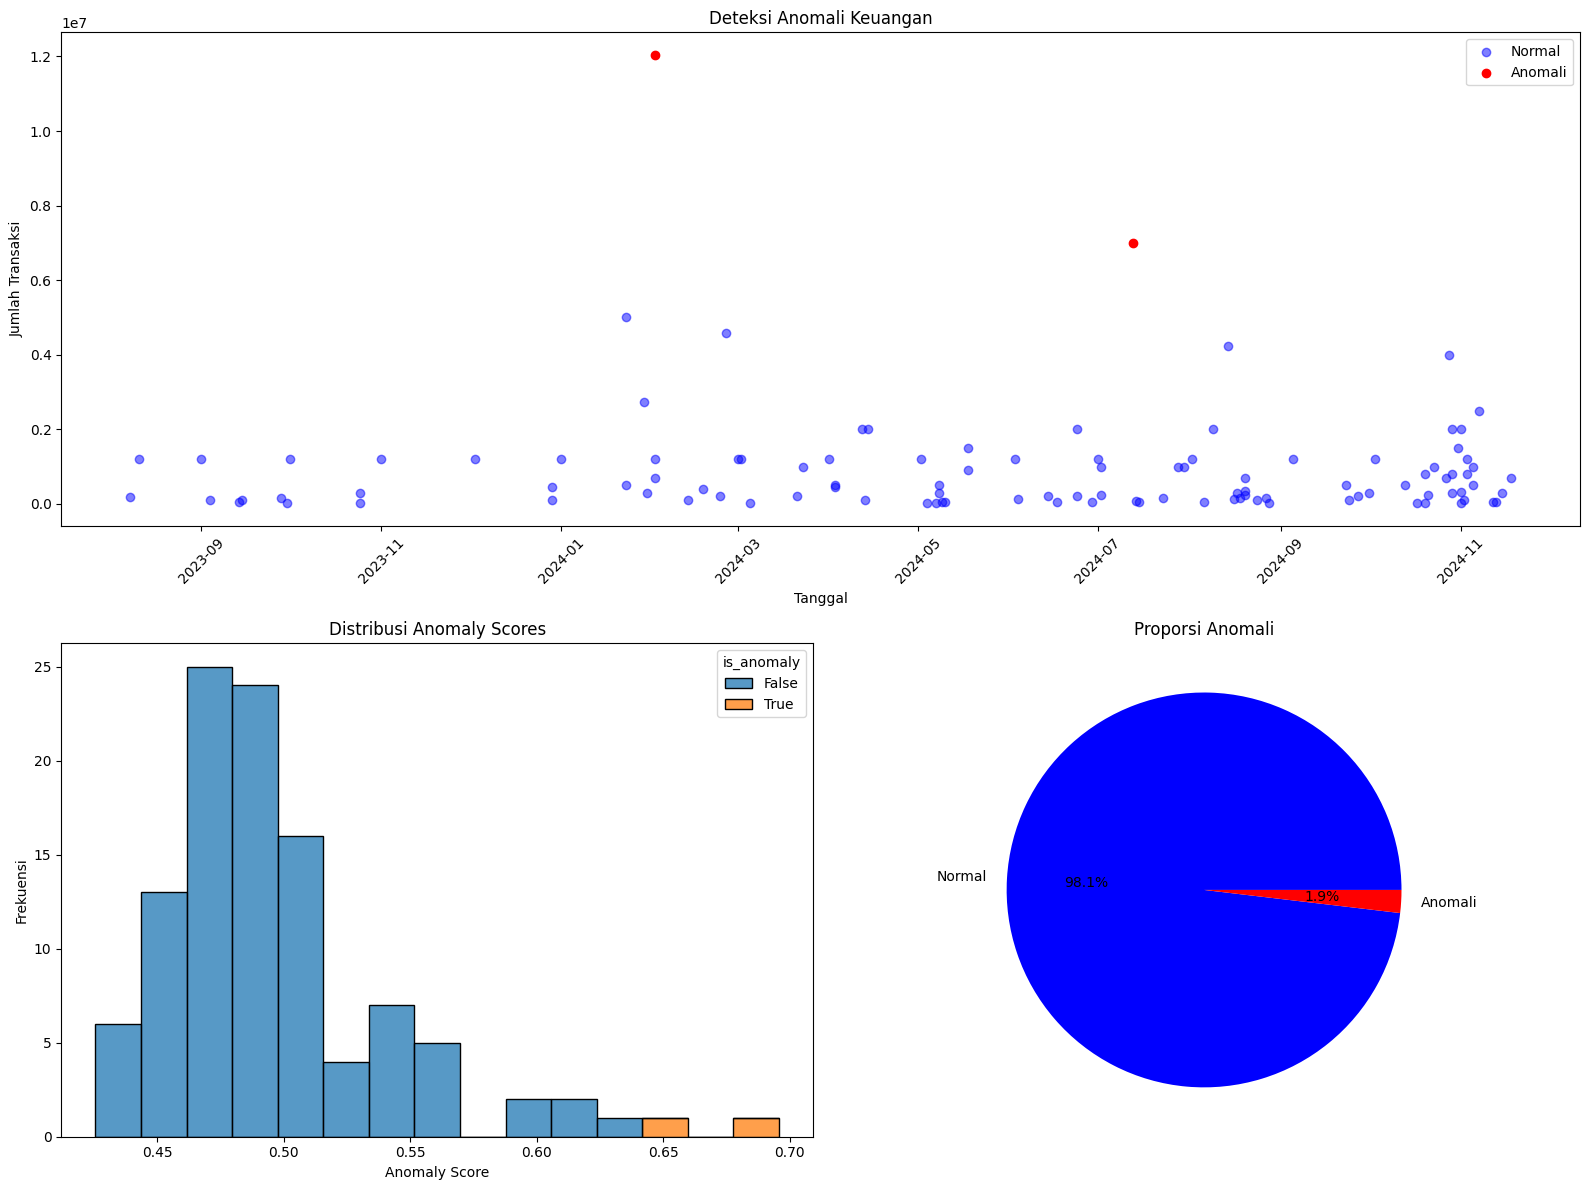

=== LAPORAN DETEKSI ANOMALI ===
Total Transaksi: 107
Jumlah Anomali: 2
Persentase Anomali: 1.87%

--- Detail Anomali ---
Tanggal: 2024-02-02
Jumlah: Rp 12,045,000.00
Anomaly Score: 0.6958
---
Tanggal: 2024-07-13
Jumlah: Rp 7,000,000.00
Anomaly Score: 0.6515
---


In [ ]:
def main_income():
    detector = AdvancedFinancialAnomalyDetector(contamination=0.01)

    # Generate synthetic data
    data = pd.read_json('income_data.json')

    # Detect anomalies
    result = detector.detect_anomalies(data)

    # Visualisasi
    detector.visualize_anomalies(result)

    # Detailed Report
    detector.detailed_anomaly_report(result)

if __name__ == "__main__":
    main_income()

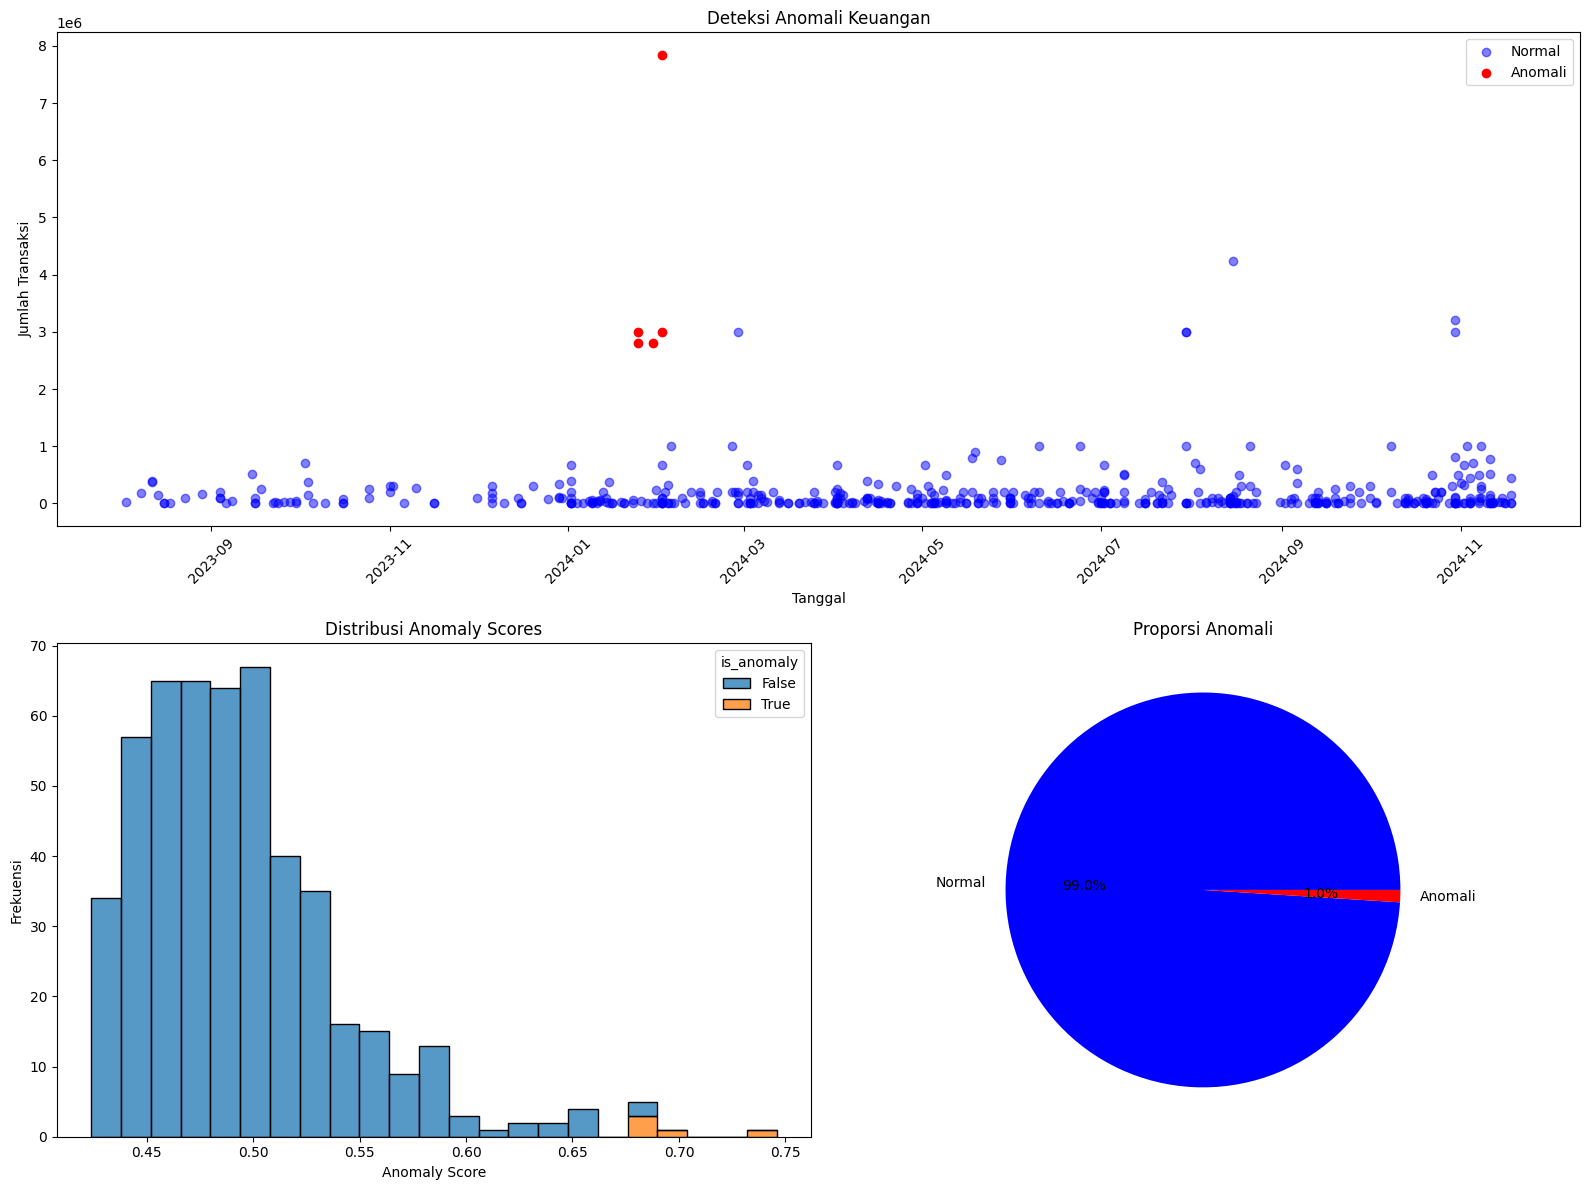

=== LAPORAN DETEKSI ANOMALI ===
Total Transaksi: 499
Jumlah Anomali: 5
Persentase Anomali: 1.00%

--- Detail Anomali ---
Tanggal: 2024-01-25
Jumlah: Rp 2,800,000.00
Anomaly Score: 0.6829
---
Tanggal: 2024-01-25
Jumlah: Rp 3,000,000.00
Anomaly Score: 0.6900
---
Tanggal: 2024-01-30
Jumlah: Rp 2,800,000.00
Anomaly Score: 0.6865
---
Tanggal: 2024-02-02
Jumlah: Rp 7,845,000.00
Anomaly Score: 0.7459
---
Tanggal: 2024-02-02
Jumlah: Rp 3,000,000.00
Anomaly Score: 0.6863
---


In [ ]:
def main_expense():
    detector = AdvancedFinancialAnomalyDetector(contamination=0.01)

    # Read dataset
    data = pd.read_json('expense_data.json')

    # Detect anomalies
    result = detector.detect_anomalies(data)

    # Visualisasi
    detector.visualize_anomalies(result)

    # Detailed Report
    detector.detailed_anomaly_report(result)

if __name__ == "__main__":
    main_expense()

# **Cek Anomali**

In [95]:
data1 = pd.read_json('income_data.json')

detector = AdvancedFinancialAnomalyDetector(contamination=0.01)
result = detector.detect_anomalies(data1)

result.sample(20)

,date,income,day_of_week,month,day_of_month,is_anomaly,anomaly_score
51,2024-06-24,2000000,0,6,24,False,0.545855
102,2024-11-07,2500000,3,11,7,False,0.552647
82,2024-10-13,500000,6,10,13,False,0.487189
1,2023-08-11,1200000,4,8,11,False,0.456310
71,2024-08-20,250000,1,8,20,False,0.425493
106,2024-11-18,700000,0,11,18,False,0.543044
17,2024-01-23,5000000,1,1,23,False,0.626024
13,2023-12-29,100000,4,12,29,False,0.546596
39,2024-05-04,20000,5,5,4,False,0.507993
12,2023-12-03,1200000,6,12,3,False,0.553147


In [96]:
data2 = pd.read_json('expense_data.json')

detector = AdvancedFinancialAnomalyDetector(contamination=0.01)
result = detector.detect_anomalies(data2)

result.sample(20)

,date,expense,day_of_week,month,day_of_month,is_anomaly,anomaly_score
474,2024-11-07,2500,3,11,7,False,0.475087
452,2024-10-30,6500,2,10,30,False,0.475876
54,2023-12-25,77808,0,12,25,False,0.579093
444,2024-10-28,750,0,10,28,False,0.529383
134,2024-02-28,2500,2,2,28,False,0.502526
345,2024-08-10,750,5,8,10,False,0.465815
110,2024-02-04,1000,6,2,4,False,0.540181
150,2024-03-08,35104,4,3,8,False,0.458165
2,2023-08-12,384000,5,8,12,False,0.513872
200,2024-04-16,750,1,4,16,False,0.434148
